# Project description
The current project aims to predict the genre of movie given the overview text that describes the movie. For example, the overview for *The Matrix* is as follows:
>Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.

From the above text, we would like to predict that the movie belongs to the "Action" and "Science Fiction" genres.

## Business object in context
We are an internet-based movie distributing company, _NetFlux_. For new movies and original content movies, we want to make sure our staff writes overviews that will represent the correct genre of the movie. This will make our recommender system work better and ultimately provide more insight for our users to what movies they want to see.



In [141]:
from IPython.display import Markdown as md
import os
from datetime import datetime
import pickle 

movies_with_overviews_path = '../data/processed/movies_with_overviews.pkl'
date_refreshed_unix = os.path.getmtime(movies_with_overviews_path)
date_refreshed = datetime.utcfromtimestamp(date_refreshed_unix).strftime('%Y-%m-%d %H:%M:%S')

with open('../data/processed/movies_with_overviews.pkl','rb') as f:
    movies_with_overviews=pickle.load(f)
with open('../data/processed/Genredict.pkl','rb') as f:
    Genre_ID_to_name=pickle.load(f)
genre_list=sorted(list(Genre_ID_to_name.keys()))
    
num_movies = len(movies_with_overviews)

display(md('''# Data
Movie overviews and genres are scraped from TMDB. Our dataset was last refreshed at **{date_refreshed}**.

The data have **{num_movies}** movie overviews.

'''.format(date_refreshed=date_refreshed, num_movies=num_movies)))


# Data
Movie overviews and genres are scraped from TMDB. Our dataset was last refreshed at **2018-10-19 17:04:50**.

The data have **1722** movie overviews.



The distribution of the genres in these movies is shown in the chart below:

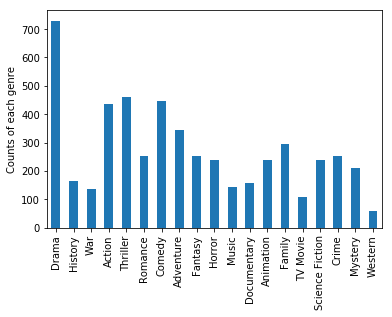

In [142]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
mwo = pd.DataFrame(movies_with_overviews)
genre_ids_series = mwo['genre_ids']
flat_genre_ids = [st for row in genre_ids_series for st in row]

flat_genre_names = [Genre_ID_to_name[id] for id in flat_genre_ids] 
genre_counts = Counter(flat_genre_names)
df = pd.DataFrame.from_dict(genre_counts, orient='index')
ax = df.plot(kind='bar')
ax.set_ylabel('Counts of each genre')
ax.legend().set_visible(False)


The top 10 movies in our dataset by popularity are listed below:

In [143]:
a=[print(x) for x in mwo.sort_values(by='popularity', ascending=False)['original_title'].head(10)]

The Lord of the Rings: The Fellowship of the Ring
The Shawshank Redemption
The Lord of the Rings: The Return of the King
Big Hero 6
Teenage Mutant Ninja Turtles
The Lord of the Rings: The Two Towers
千と千尋の神隠し
The Godfather
Terminator 2: Judgment Day
Twilight


# Models and Features

We are currently using the following models to train against the dataset with the associated feature engineering:
1. C-SVM
    - The overviews are using a **bag of words** model and have been vectorized and transformed using **TF_IDF**.
2. Naive Bayes
    - The overviews are using a **bag of words** model and have been vectorized with a **Count Vectorizer**.
3. Simple neural network (not deep)
    - The overviews were tokenized with a **white space tokenizer**. Stop words were removed. Overviews were treated as **bag of words**, which each word being converted to a vector, using the GoogleNews-vectors-negative300.bin model.  The **arithmetic mean** of the words represented the overview. Taking the top 3 genres predicted for each movie.



### C-SVM

#### Metrics for each genre

In [144]:
with open('../models/classifier_svc.pkl','rb') as f:
    classif=pickle.load(f)
with open('../data/processed/X_tfidf.pkl','rb') as f:
    X=pickle.load(f)
with open('../data/processed/Y.pkl','rb') as f:
    Y=pickle.load(f)
    
from src.utils.eval_metrics import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

indecies = range(len(movies_with_overviews))
X_train, X_test, Y_train, Y_test, train_movies, test_movies = train_test_split(X, Y, indecies, test_size=0.20, random_state=42)
genre_names=list(Genre_ID_to_name.values())
predstfidf=classif.predict(X_test)
print (classification_report(Y_test, predstfidf, target_names=genre_names))

                 precision    recall  f1-score   support

         Action       0.38      0.41      0.40        70
      Adventure       0.33      0.45      0.38        51
      Animation       0.37      0.36      0.36        59
         Comedy       0.62      0.65      0.63       142
          Crime       0.32      0.58      0.42        38
    Documentary       0.49      0.59      0.54        81
          Drama       0.46      0.62      0.52       104
         Family       0.00      0.00      0.00        36
        Fantasy       0.50      0.17      0.25        18
        History       0.36      0.59      0.45        74
         Horror       0.34      0.51      0.41        41
          Music       0.66      0.60      0.63        35
        Mystery       0.36      0.29      0.32        45
        Romance       0.38      0.40      0.39        45
Science Fiction       0.70      0.57      0.63        28
       TV Movie       0.58      0.65      0.61        46
       Thriller       0.00    

/usr/local/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Precision and Recall for the overall model

In [145]:
predictions = generate_predictions(Genre_ID_to_name, X_test, predstfidf)
precs, recs = precsc_recs(test_movies, movies_with_overviews, Genre_ID_to_name, predictions)

prec_mean = np.mean(np.asarray(precs))
rec_mean = np.mean(np.asarray(recs))

md('''Precision: {prec_mean}

Recall: {rec_mean}

'''.format(prec_mean=prec_mean, rec_mean=rec_mean))

Precision: 0.45962732919254656

Recall: 0.47806763285024156



#### Example predictions for a small sample

In [146]:
predictions=[]
actuals = []
for i in range(X_test.shape[0]):
    pred_genres=[]
    actual_genres=[]
    movie_label_scores=predstfidf[i]
    actual_scores = Y_test[i]
#     print movie_label_scores
    for j in range(len(movie_label_scores)):
        #print j
        if movie_label_scores[j]!=0:
            genre=Genre_ID_to_name[genre_list[j]]
            pred_genres.append(genre)
        if actual_scores[j]!=0:
            genre=Genre_ID_to_name[genre_list[j]]
            actual_genres.append(genre)
    predictions.append(pred_genres)
    actuals.append(actual_genres)
for i in range(X_test.shape[0]):
    if i%50==0 and i!=0:
        print ('MOVIE: ',movies_with_overviews[test_movies[i]]['title'],
               '\nPREDICTION: ',','.join(predictions[i]), 
               '\nActual: ', ','.join(actuals[i]), '\n')

MOVIE:  The Three Burials of Melquiades Estrada 
PREDICTION:  Drama,Action,Thriller,Crime 
Actual:  Adventure,Drama,Western,Crime,Mystery 

MOVIE:  MouseHunt 
PREDICTION:  Comedy 
Actual:  Comedy,Family 

MOVIE:  The Untold History of the United States 
PREDICTION:  Animation,Documentary 
Actual:  History,Documentary 

MOVIE:  Halloweentown 
PREDICTION:  Adventure,Fantasy,Animation,Action 
Actual:  Adventure,Fantasy,Comedy,Family 

MOVIE:  City By The Sea 
PREDICTION:  Drama,Thriller,Crime,TV Movie 
Actual:  Drama,Crime,Mystery 

MOVIE:  Age of Uprising: The Legend of Michael Kohlhaas 
PREDICTION:  Adventure,Action 
Actual:  Drama,History 



### Naive Bayes

#### Metrics for each genre

In [163]:
with open('../models/classifier_nb.pkl','rb') as f:
    classif=pickle.load(f)
with open('../data/processed/X.pkl','rb') as f:
    X=pickle.load(f)
with open('../data/processed/Y.pkl','rb') as f:
    Y=pickle.load(f)
    
from src.utils.eval_metrics import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

indecies = range(len(movies_with_overviews))
X_train, X_test, Y_train, Y_test, train_movies, test_movies = train_test_split(X, Y, indecies, test_size=0.20, random_state=42)
genre_names=list(Genre_ID_to_name.values())
preds=classif.predict(X_test)
print (classification_report(Y_test, preds, target_names=genre_names))

                 precision    recall  f1-score   support

         Action       0.46      0.40      0.43        70
      Adventure       0.47      0.39      0.43        51
      Animation       0.42      0.27      0.33        59
         Comedy       0.67      0.68      0.67       142
          Crime       0.42      0.50      0.46        38
    Documentary       0.57      0.60      0.59        81
          Drama       0.57      0.52      0.54       104
         Family       0.43      0.44      0.44        36
        Fantasy       0.00      0.00      0.00        18
        History       0.44      0.49      0.46        74
         Horror       0.55      0.59      0.56        41
          Music       0.57      0.71      0.63        35
        Mystery       0.45      0.40      0.42        45
        Romance       0.44      0.36      0.40        45
Science Fiction       0.61      0.61      0.61        28
       TV Movie       0.50      0.67      0.57        46
       Thriller       0.55    

#### Precision and Recall for the overall model

In [164]:
predictions = generate_predictions(Genre_ID_to_name, X_test, preds)
precs, recs = precsc_recs(test_movies, movies_with_overviews, Genre_ID_to_name, predictions)

prec_mean = np.mean(np.asarray(precs))
rec_mean = np.mean(np.asarray(recs))

md('''Precision: {prec_mean}

Recall: {rec_mean}

'''.format(prec_mean=prec_mean, rec_mean=rec_mean))

Precision: 0.5102357948010122

Recall: 0.5255072463768117



#### Example predictions for a small sample

In [165]:
predictions=[]
actuals = []
for i in range(X_test.shape[0]):
    pred_genres=[]
    actual_genres=[]
    movie_label_scores=preds[i]
    actual_scores = Y_test[i]
#     print movie_label_scores
    for j in range(len(movie_label_scores)):
        #print j
        if movie_label_scores[j]!=0:
            genre=Genre_ID_to_name[genre_list[j]]
            pred_genres.append(genre)
        if actual_scores[j]!=0:
            genre=Genre_ID_to_name[genre_list[j]]
            actual_genres.append(genre)
    predictions.append(pred_genres)
    actuals.append(actual_genres)
for i in range(X_test.shape[0]):
    if i%50==0 and i!=0:
        print ('MOVIE: ',movies_with_overviews[test_movies[i]]['title'],
               '\nPREDICTION: ',','.join(predictions[i]), 
               '\nActual: ', ','.join(actuals[i]), '\n')

MOVIE:  The Three Burials of Melquiades Estrada 
PREDICTION:  Drama,Action,Thriller,Crime 
Actual:  Adventure,Drama,Western,Crime,Mystery 

MOVIE:  MouseHunt 
PREDICTION:  Comedy,Romance,Family 
Actual:  Comedy,Family 

MOVIE:  The Untold History of the United States 
PREDICTION:  History,Documentary 
Actual:  History,Documentary 

MOVIE:  Halloweentown 
PREDICTION:  Adventure,Fantasy,Animation,Family 
Actual:  Adventure,Fantasy,Comedy,Family 

MOVIE:  City By The Sea 
PREDICTION:  Drama,Crime 
Actual:  Drama,Crime,Mystery 

MOVIE:  Age of Uprising: The Legend of Michael Kohlhaas 
PREDICTION:  Adventure,Drama,Action 
Actual:  Drama,History 



In [166]:
print(movies_with_overviews[test_movies[100]])
print(Genre_ID_to_name[35])
print(Genre_ID_to_name[10751])
test_movies[100]
classif.predict(X_test[100])

{'vote_count': 454, 'id': 6283, 'video': False, 'vote_average': 6.3, 'title': 'MouseHunt', 'popularity': 9.145, 'poster_path': '/gQ3Nyb3UkRHyuiN96MNmKmREc6F.jpg', 'original_language': 'en', 'original_title': 'MouseHunt', 'genre_ids': [35, 10751], 'backdrop_path': '/8NPT9q8UurQ7MIUjMeaZxaDa7WE.jpg', 'adult': False, 'overview': "Down-on-their luck brothers, Lars and Ernie Smuntz, aren't happy with the crumbling old mansion they inherit... until they discover the estate is worth millions. Before they can cash in, they have to rid the house of it's single, stubborn occupant: a tiny and tenacious mouse.", 'release_date': '1997-12-19'}
Comedy
Family


array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]])

### Simple Neural Network with Word2Vec features

#### Metrics for each genre

In [151]:
from keras.models import load_model
from sklearn.preprocessing import MultiLabelBinarizer
with open('../data/processed/textual_features.pkl','rb') as f:
    (X,Y)=pickle.load(f)
model_textual = load_model('../models/overview_nn.h5')

indecies = range(len(movies_with_overviews))
X_train, X_test, Y_train, Y_test, train_movies, test_movies = train_test_split(X, Y, indecies, test_size=0.20, random_state=42)
genre_names=list(Genre_ID_to_name.values())
Y_preds=model_textual.predict(X_test)

Y_preds_binary = []
for row in Y_preds:
    predicted = np.argsort(row)[::-1][:3]
    predicted_genre_Y = [1 if k in predicted else 0 for k in range(len(row)) ]
    Y_preds_binary.append(predicted_genre_Y)

print (classification_report(Y_test, np.array(Y_preds_binary), target_names=genre_names))

                 precision    recall  f1-score   support

         Action       0.49      0.43      0.46        70
      Adventure       0.43      0.45      0.44        51
      Animation       0.51      0.36      0.42        59
         Comedy       0.56      0.75      0.64       142
          Crime       0.38      0.39      0.38        38
    Documentary       0.52      0.49      0.51        81
          Drama       0.53      0.59      0.56       104
         Family       0.43      0.33      0.38        36
        Fantasy       0.91      0.56      0.69        18
        History       0.44      0.47      0.46        74
         Horror       0.50      0.46      0.48        41
          Music       0.74      0.80      0.77        35
        Mystery       0.56      0.40      0.47        45
        Romance       0.45      0.29      0.35        45
Science Fiction       0.55      0.61      0.58        28
       TV Movie       0.38      0.37      0.37        46
       Thriller       0.63    

#### Precision and Recall for the overall model

In [152]:
predictions = generate_predictions(Genre_ID_to_name, X_test, Y_preds_binary)
precs, recs = precsc_recs(test_movies, movies_with_overviews, Genre_ID_to_name, predictions)

prec_mean = np.mean(np.asarray(precs))
rec_mean = np.mean(np.asarray(recs))

md('''Precision: {prec_mean}

Recall: {rec_mean}

'''.format(prec_mean=prec_mean, rec_mean=rec_mean))

Precision: 0.5169082125603865

Recall: 0.5496135265700484



#### Example predictions for a small sample

In [153]:
for i in range(X_test.shape[0]):
    if i%50==0 and i!=0:
        print ('MOVIE: ',movies_with_overviews[test_movies[i]]['title'],
               '\nPREDICTION: ',','.join(predictions[i]), 
               '\nActual: ', ','.join(actuals[i]), '\n')

MOVIE:  The Three Burials of Melquiades Estrada 
PREDICTION:  Action,Western,Thriller 
Actual:  Adventure,Drama,Western,Crime,Mystery 

MOVIE:  MouseHunt 
PREDICTION:  Fantasy,Comedy,Family 
Actual:  Comedy,Family 

MOVIE:  The Untold History of the United States 
PREDICTION:  Drama,History,Documentary 
Actual:  History,Documentary 

MOVIE:  Halloweentown 
PREDICTION:  Fantasy,Horror,Family 
Actual:  Adventure,Fantasy,Comedy,Family 

MOVIE:  City By The Sea 
PREDICTION:  Drama,Crime,TV Movie 
Actual:  Drama,Crime,Mystery 

MOVIE:  Age of Uprising: The Legend of Michael Kohlhaas 
PREDICTION:  Adventure,Drama,Action 
Actual:  Drama,History 



In [154]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../notebooks/static/custom.css", "r").read()
    return HTML(styles)
css_styling()